# Drift Detection Summary

**Columns exhibiting drift**  
- `num_feature_3`  
- `num_feature_5`  
- `num_feature_8`  
- `cat_feature_2`

**Approximate drift dates (first window of each event)**  
- `num_feature_3`: 2023‑01‑16  
- `num_feature_5`: 2023‑01‑10  
- `num_feature_8`: 2023‑01‑08 and 2023‑01‑26  
- `cat_feature_2`: 2023‑01‑25

**Number of drift events**  
- `num_feature_3`: **1**  
- `num_feature_5`: **1**  
- `num_feature_8`: **2**  
- `cat_feature_2`: **1**

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency

# Assignment

In this assignment you will each work individually to assess the above dataset for drift. There are 10 numerical columns, 3 categorical columns, and one date column. You must check each numerical and categorical column for drift. 

Note, you must use the KS statistic and p-value and the chi-square statistic and p-value as your drift metrics, and attempt to identify:

- which columns have drift?
- approximately when does the column drift? 
- how many times does the column drift?

Please feel free to use the following parameters when looking for drift:

- Reference set: first 7 days of the dataset (static)
- Window size for test set: 7 days
- Moving window: move by 1 day

Note that it is very easy to verify the drift because you are given the entire dataset, and the simulated drift in the example is abrupt and extreme, but recall that when a model is running live, you do not have the advantage of identifying drift retrospectively, you are looking for as it is happening, and real data drift can be subtle. As such, you must prove that you can identify the drift using the drift metrics. 

# Evidence for Drift
The following code cells compute Kolmogorov–Smirnov p‑values for the ten numerical
features and Chi‑square p‑values (with +1 Laplace smoothing) for the three categorical
features against a static 7‑day reference.  
A Bonferroni‑adjusted threshold of **0.00385** (0.05 ÷ 13) is applied.  
Consecutive flagged windows are merged into single drift events.

In [ ]:
# Load and prep
df = pd.read_csv('synthetic_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

num_cols = [c for c in df.columns if c.startswith('num_')]
cat_cols = [c for c in df.columns if c.startswith('cat_')]

start_date = df['datetime'].min().normalize()
ref_end = start_date + timedelta(days=7)

reference = df[df['datetime'] < ref_end]

window_size = timedelta(days=7)
step = timedelta(days=1)

window_starts = []
pvals = {col: [] for col in num_cols + cat_cols}

cur_start = ref_end
while cur_start + window_size <= df['datetime'].max() + timedelta(seconds=1):
    cur_end = cur_start + window_size
    window = df[(df['datetime'] >= cur_start) & (df['datetime'] < cur_end)]
    if window.empty:
        break
    window_starts.append(cur_start)

    # numerical KS
    for col in num_cols:
        pv = ks_2samp(reference[col], window[col]).pvalue
        pvals[col].append(pv)

    # categorical Chi‑square with +1 smoothing
    for col in cat_cols:
        ref_counts = reference[col].value_counts()
        win_counts = window[col].value_counts()
        cats = ref_counts.index.union(win_counts.index)
        ref_vec = ref_counts.reindex(cats, fill_value=0).values + 1
        win_vec = win_counts.reindex(cats, fill_value=0).values + 1
        contingency = np.vstack([ref_vec, win_vec])
        pv = chi2_contingency(contingency, correction=False)[1]
        pvals[col].append(pv)

    cur_start += step

pval_df = pd.DataFrame(pvals, index=window_starts)
alpha = 0.05 / 13
flags = pval_df < alpha

/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_9135/3847895452.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])


In [6]:
flags.head()

,num_feature_1,num_feature_2,num_feature_3,num_feature_4,num_feature_5,num_feature_6,num_feature_7,num_feature_8,num_feature_9,num_feature_10,cat_feature_1,cat_feature_2,cat_feature_3
2023-01-08,False,False,False,False,False,False,False,True,False,False,False,False,False
2023-01-09,False,False,False,False,False,False,False,True,False,False,False,False,False
2023-01-10,False,False,False,False,True,False,False,True,False,False,False,False,False
2023-01-11,False,False,False,False,True,False,False,True,False,False,False,False,False
2023-01-12,False,False,False,False,True,False,False,True,False,False,False,False,False


In [7]:
# Summarise drift events
events = {}
for col in flags.columns:
    event_dates = []
    series = flags[col]
    in_event = False
    for i, (ts, drifted) in enumerate(series.items()):
        if drifted and not in_event:
            in_event = True
            event_dates.append(ts)
        if not drifted:
            in_event = False
    if event_dates:
        events[col] = event_dates

# Print summary
print("=== Drift Events Summary ===")
for col, dates in events.items():
    print(f"{col}: {len(dates)} event(s) → {', '.join(d.strftime('%Y-%m-%d') for d in dates)}")


=== Drift Events Summary ===
num_feature_3: 1 event(s) → 2023-01-16
num_feature_5: 1 event(s) → 2023-01-10
num_feature_8: 2 event(s) → 2023-01-08, 2023-01-26
cat_feature_2: 1 event(s) → 2023-01-25


# Visual Evidence

We can see in the below line plots the line up with our testing outputs summary. num_feature_5 almost has 2 drift events, but technically it does not quite stabilize again like num_feature 8.

Together, the quantitative test statistics and visual diagnostics present consistent evidence for which features drifted, when those drifts began, and how often each feature crossed the control limits.

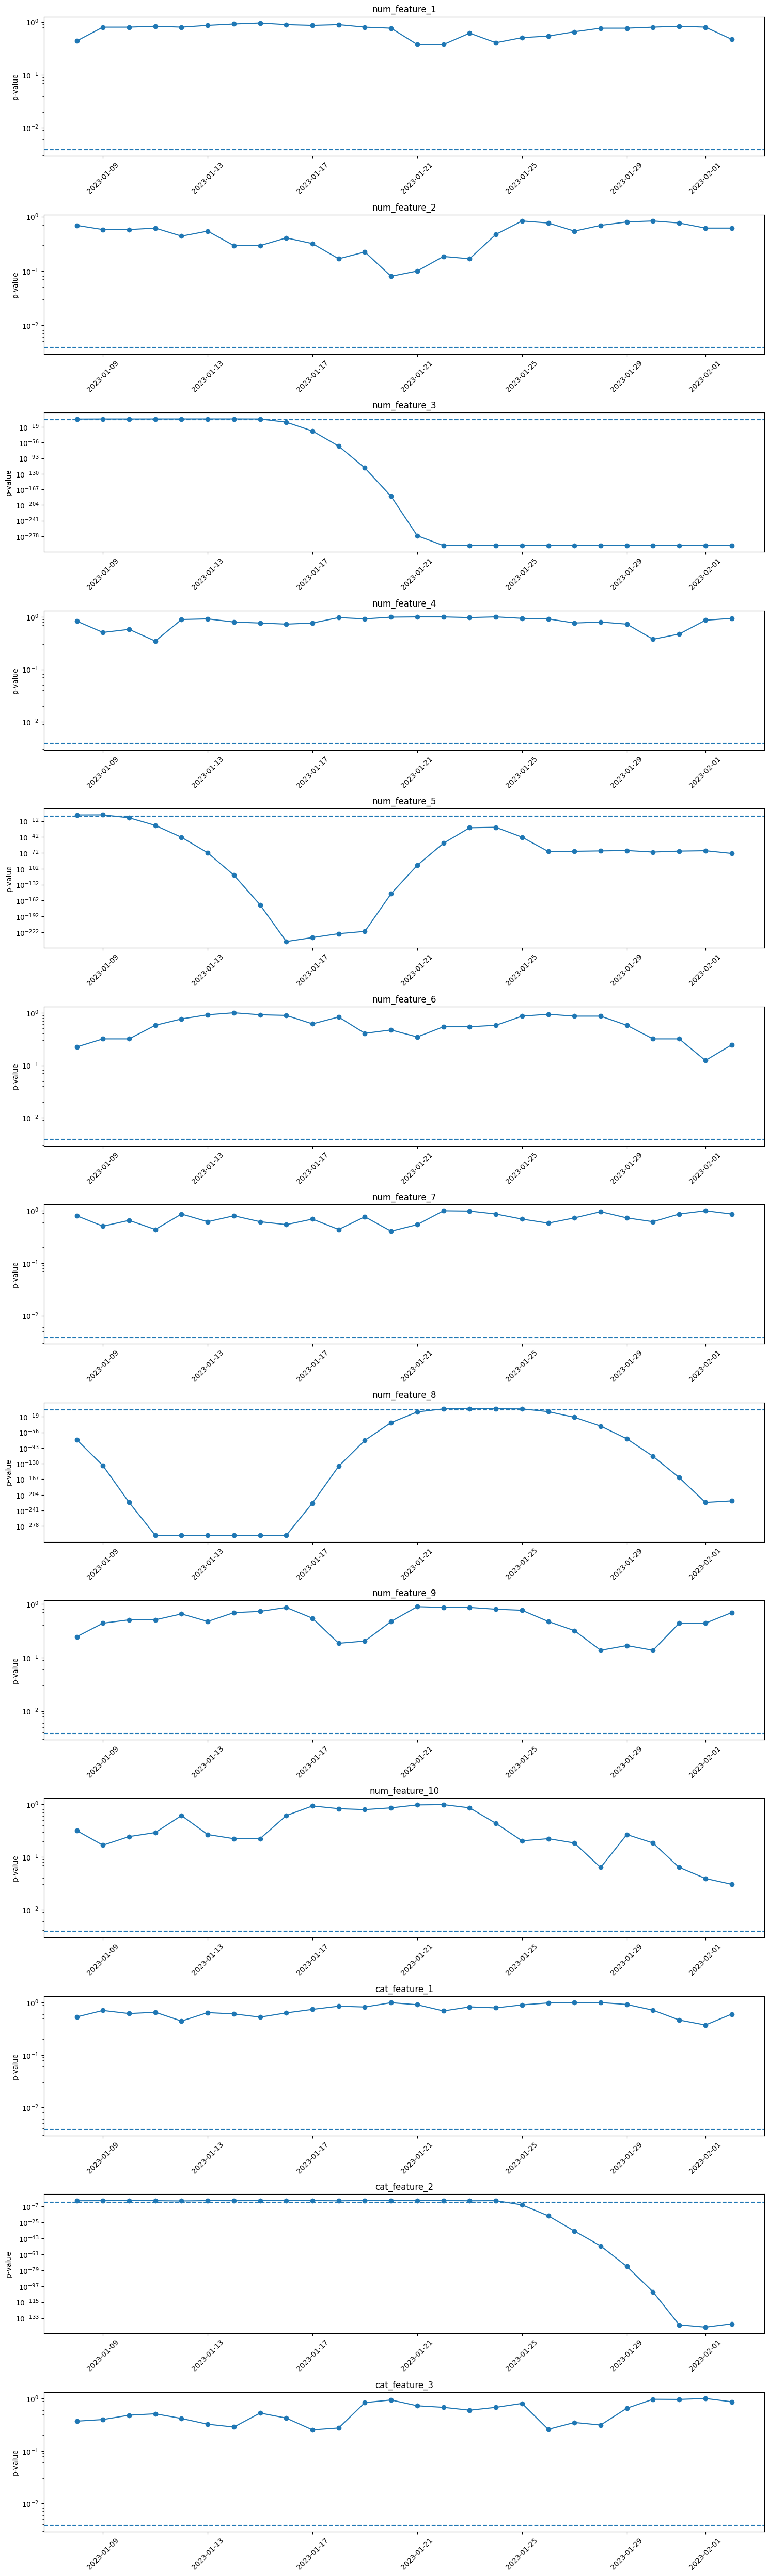

In [13]:
# P‑value line plots
plt.figure(figsize=(15, 50))
plot_cols = num_cols + cat_cols
pval_plot_df = pval_df.replace(0, 1e-300)  # avoid log(0) issues
for i, col in enumerate(plot_cols, 1):
    plt.subplot(len(plot_cols), 1, i)
    plt.plot(pval_plot_df.index, pval_plot_df[col], marker='o')
    plt.axhline(alpha, linestyle='--')
    plt.title(col)
    plt.yscale('log')
    plt.ylabel('p‑value')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Format

Please submit, as your solution, a python notebook with all code and visualizations that helped you identify the drift. At the very top of your notebook, please clearly state your answers to the above 3 questions. You will be graded on accuracy and also the provided evidence for drift in the form of drift metric calculations and visualizations. Please include the header "Evidence for Drift" above the code and outputs that show how you arrived at your answer. If you generated external files, such as plots, please include these in one pdf file and upload it along with the notebook.